In [1]:
import logging
import re
import pandas as pd
import numpy as np

from dataclasses import dataclass
from datetime import date, datetime, timezone, timedelta
from typing import Dict, List
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import ASYNCHRONOUS
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
from termcolor import colored

from scc_co2_buz.domain.models.well_data import IO
from scc_co2_buz.helpers.utils.io_normalize import db_types 
from scc_co2_buz.helpers.utils.get_utc import get_utc_now
from scc_co2_buz.domain.models.tag import TagModel

In [ ]:
map_to_tag = {    
    '9-BUZ-3-RJS': 'well injection C', '9-BUZ-1-RJS':'well injection A', '9-BUZ-6-RJS': 'well injection F', '9-BUZ-5-RJS': 'well injection E', '9-BUZ-4-RJS' : 'well injection D', '9-BUZ-2-RJS' : 'well injection B'
}

In [ ]:
class InfluxDbConfig:
    """"
    ConfigClass for InfluxDb
    """
    def __init__(self) -> None:
        self.url = "http://10.136.226.25:8086"
        self.token = "ganimede@2050"
        self.org = "PETROBRAS"
        self.bucket = "vip"
        self.write_options = ASYNCHRONOUS

In [ ]:
class InfluxDBadapter:
    def __init__(self, config: InfluxDbConfig) -> None:
        self.config = config
        self.client = InfluxDBClient(config.url, config.token, debug=None, org=config.org)
        self.log = logging.getLogger(name='repository')
        print("connecting to P-77 database...")
    def closeConnection(self):
        self.client.close()
        self.log.info('connection to database closed')
    def AddTag(self, tag: TagModel) -> Dict[bool, Exception]:
        try:
            _point = self.makeTagPoint(tag)
            self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, record=[_point], org=self.config.org)
            self.log.info('tag ' + tag.tag + ' sent to database')

        except Exception as e:
            msg = 'error sending tag ' + tag.tag + ' to database ' + e.args
            self.log.error(msg)
            return None, e
        return (True, None)

    def addAllTags(self, tags: List[TagModel]) -> Dict[bool, Exception]:
        try:
            points = [self.makeTagPoint(t) for t in tags]
            db = self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, org=self.config.org, record=points)
            db.get()
        except Exception as e:
            msg = 'error sending tags to database ' + str(e)
            self.log.error(msg)
            return None, e
        return (True, None)

    def makeTagPoint(self, tag: List[TagModel]) -> Point:
        tag_field = 'DIAGNOSTIC' if tag.io in [
            IO.HEARTBEAT, IO.GENERALDIAG] else 'well'
        return Point("IO").tag(tag_field, tag.wn).field(tag.io, db_types[tag.io](tag.value)).time(tag.timestamp)

    def getData(self, start: date, end: date, tags:[TagModel] = None) -> DataFrame:
        params = {
            "start":  datetime.fromtimestamp(datetime.timestamp(start), tz=timezone.utc),
            "stop": datetime.fromtimestamp(datetime.timestamp(end), tz=timezone.utc),
            "bucket": self.config.bucket
        }
        filter_io = ''
        db_cols = list(set([tag.io for tag in tags]))
        for io in db_cols:
            if io != db_cols[-1]:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\" or '
            else:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\"'
        query = 'from(bucket: bucket)\
            |> range(start: start, stop: stop)\
            |> filter(fn: (r) => r["_measurement"] == "IO")\
            |> filter(fn: (r) => ' + filter_io + ')\
            |> yield(name: "last")'
        query_api = self.client.query_api()
        result = query_api.query(
            org=self.config.org, query=query, params=params)
        results = []
        for table in result:
            for record in table.records:
                results.append((datetime.fromtimestamp(
                    record.get_time().timestamp(), tz=timezone.utc), record.get_value(), record['well'], record.get_field()))
        df = pd.DataFrame(data=results, columns=['time', 'value', 'oil_well', 'io'])
        df2 = df.pivot(index=['time', 'oil_well'], columns=['io'], values=['value']).reset_index()
        df2.columns = [c[{'time': 0, 'oil_well': 0, 'value': 1}[c[0]]] for c in df2.columns]
        return df2

In [ ]:
#repo = InfluxDBadapter(config=InfluxDbConfig())
#tag1 = TagModel(paths=[None, None],tag='PIT_1244007A',conversion=[0,1,0,1], tp='float', io="P-JUZ-CKP-A")
#tag2 = TagModel(paths=[None, None],tag='PIT_1244007B',conversion=[0,1,0,1], tp='float', io="P-JUZ-CKP-B")

In [ ]:
#end = get_utc_now()
#start = get_utc_now() - timedelta(seconds=259200)
# comentando para não ficar baixando dados do banco
#df = repo.getData(start=start, end=end, tags=[tag1,tag2])
#df['oil_well'] = df['oil_well'].apply(lambda x: map_to_tag[x])
#df = df.rename(columns={IO.PJCKPA: "PIT-1244007", IO.PJCKPB:"PIT-1244008"})
#df_select = df.query('oil_well=="well injection C" or oil_well == "well injection D"')
#df_select.tail()

In [21]:
df_select=pd.read_csv("output_data.csv")
df_select['time'] = df_select['time'].apply(lambda x: datetime.strptime(x.split('+')[0], '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours=3)) 
delta = df_select['time'].max().timestamp() - df_select['time'].min().timestamp()
expsamples = 2 * delta / 5
print("Expected number of samples 2 x seconds / 5 = " +  str(int(expsamples)))
print("Received number of samples = " +  str(len(df_select)))
print("lost samples = " + str(2*delta/5 - len(df_select)))
print(" % lost = " + str(str(( 2 * delta/ 5 - len(df_select))/(2*delta/5))))

Expected number of samples 2 x seconds / 5 = 84620
Received number of samples = 78224
lost samples = 6396.925513935086
 % lost = 0.0755950785823261


In [ ]:
df_select.head()

In [ ]:
df_select[df_select['oil_well'] == 'well injection D']['PIT-1244007'].hist(bins=100)

In [ ]:
df_select[df_select['oil_well'] == 'well injection D']['PIT-1244008'].hist(bins=100)

In [22]:
@dataclass
class Color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = "\033[1;32;48m"
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

def print_colored(msg:str, color: Color = Color.GREEN):
    print("{} {} {}".format(color,msg, Color.END))
def calcNormStd(df, well, pit, delta = timedelta(seconds=60)):
    start = df['time'].min()
    end = start + delta
    max_norm_std = -1.0
    
    time_limit = df.iloc[-1]['time'] - delta
    iteration = 0
    total_iterations = int((time_limit.timestamp() - start.timestamp()) / 60 )    
    values = []
    iterations = []
    #time_limit = 1000 * delta + start
    max_sample_data = None
    
    while start <= time_limit:
        mask = (df['oil_well'] == well) & (df['time'] >= start) & (df['time'] < end) 
        current_data = df.loc[mask][pit]
        current_norm_std = current_data.std() / current_data.mean()
        iteration += 1
        clear_output(wait=True)
        msg = f'iteration = {iteration} \n > progress = {100*iteration/total_iterations if iteration < total_iterations else 100.00} %'
        color = "green"
        print_colored(msg, Color.GREEN)
        if current_norm_std > max_norm_std:
            max_norm_std = current_norm_std 
            values.append(max_norm_std) 
            iterations.append(iteration)
            print(max_norm_std)
            max_sample_data = current_data
        start = start + delta
        end = end + delta
        
    df_std = pd.DataFrame({'iteration': iterations, 'variation': values})
    df_std.plot(x='iteration', y='variation', kind='line')
    plt.show()    
    return f'coefficient of variation = {100*max_norm_std} %'

def toFloat(x):
    
    if type(x) == float or type(x) == int:
        return x
    
    x = x.strip()
    x = x.replace(' ','')
    
    result1 = None
    result2 = None
    
    try:
        result1 = re.findall(r'\d+\.\d+', x)
        result2 = re.findall(r'\d+', x)
    except Exception as e:
        print(str(e) + str(x))
        return np.nan
        
    if len(result1) > 0 and type(result1) == list:
        return float(result1[0])
    elif len(result2) > 0 and type(result2) == list:
        return float(result2[0])
    else:
        # comm fail from PI Web API
        return np.nan

def checkSupress(df, start, end, instrument):
    mask = (df['time'] >= start) & (df['time'] <= end)
    supression = df.loc[mask][instrument]
    variation = 100 * ( supression.max() - supression.min() ) / (supression.mean() + 0.0000000001)
    if variation >= 2.0:
        print_colored(' > supressed by ' + str(instrument) + '\n  in time: ' + str(df.loc[mask]['time'].iloc[-1]) + '\n  with variation : ' + str(variation) + ' %', Color.YELLOW)
        return True
    return False   

def treatCSVFromDatalink(file):
    """
    treat csv from datalink
    """
    df = pd.read_csv(file)
    
    for col in df.columns:
        if col != 'time':
            if 'SDY' in col:
                df[col] = df[col].apply(lambda x: 1 if x == 'On' else 0)
            else:
                df[col] = df[col].apply(lambda x: toFloat(x))
                std = df[col].std()
                mean = df[col].mean()
                df[col] = df[col].apply(lambda x: (x - mean) / (std + 0.000000000001))
        else:
            df[col] = df[col].apply(lambda x: datetime.strptime(x.replace('nov','11'), '%d-%m-%y %H:%M:%S'))
    
    #df['time'] = df['time'].apply(lambda x: datetime.strptime(x.replace('nov','11'), '%d-%m-%y %H:%M:%S'))
    #df['P77_ZIT_1244002C'] = df['P77_ZIT_1244002C'].apply(lambda x: toFloat(x))
    #df['P77_ZIT_1244002D'] = df['P77_ZIT_1244002D'].apply(lambda x: toFloat(x)) 
    df = df.dropna()
    return df

In [23]:
start = df_select.iloc[0]['time']
end = df_select.iloc[-1]['time']
df = treatCSVFromDatalink('data.csv')
supress = df.loc[(df['time'] >= start) & (df['time'] < end)]
supress.head()

,time,P77_ZIT_1244001C,P77_ZIT_1244001D,P77_ZIT_1244002C,P77_ZIT_1244002D,P77_PIT_1244007C,P77_PIT_1244008C,P77_PIT_1244007D,P77_PIT_1244008D,P77_SDY_1210002C,P77_SDY_1210002D
2685,2022-11-16 20:46:00,0.0,0.0,-0.359914,-0.224411,-0.585888,-0.587780,0.271143,0.259994,1,1
2686,2022-11-16 20:47:00,0.0,0.0,-0.359914,-0.224411,-0.590097,-0.588492,0.150772,0.144702,1,1
2687,2022-11-16 20:48:00,0.0,0.0,-0.359914,-0.225075,-0.597113,-0.598995,-0.107526,-0.103501,1,1
2688,2022-11-16 20:49:00,0.0,0.0,-0.359914,-0.224734,-0.600730,-0.599745,-0.239111,-0.228529,1,1
2689,2022-11-16 20:50:00,0.0,0.0,-0.359914,-0.224411,-0.601322,-0.601079,-0.256545,-0.260874,1,1


In [ ]:
calcNormStd(df_select, 'well injection C', 'PIT-1244007')

In [ ]:
calcNormStd(df_select, 'well injection C', 'PIT-1244008')

In [ ]:
calcNormStd(df_select, 'well injection D', 'PIT-1244007')

In [ ]:
calcNormStd(df_select, 'well injection D', 'PIT-1244008')

In [28]:
class Signal:
    def __init__(self):
        self.io_input = []
        self.io_ouput = []
        self.alarm_values = [0,0,0,0,0,0]
        self.sample_values = [0,0,0,0,0,0]
        self.values = [0,0,0,0,0,0,0,0,0]
        
    def check_alarm(self, supress , instrument_supress, time_, i, v, set_point_ll = -67 * 100):
        self.alarm_values.append(1.0 if v <= set_point_ll else 0.0 ) 
        self.alarm_values.pop(0)
        self.sample_values.append(v)
        self.sample_values.pop(0)
        check = 1
    
        if sum(self.alarm_values) == 6:
            
            # check supress 
            start = time_.floor(freq='MIN') - timedelta(seconds=120) 
            end = time_.floor(freq='MIN') 
            
            mask = (supress['time'] >= start) & (supress['time'] <= end)
            supression = supress.loc[mask][instrument_supress]
            print(supression)
            
            if checkSupress(supress, start, end, instrument_supress):
                #print('-1')  
                self.alarm_values = [0,0,0,0,0,0]
                self.sample_values = [0,0,0,0,0,0]
                return 0
        
            #check = 0 if checkSupress(supress, start, end, instrument_supress) else 1
            print_colored(f'{start} , {end}',Color.BLUE)
            color = Color.RED if check == 1 else Color.GREEN
            # print alarm
            print_colored('iter = '+ str(i), color)
            print_colored('time = '+ str(time_), color)
            print_colored('signal inputs '+ str(self.values) + ' kPa', color)
            print_colored('signal outputs'+ str(self.sample_values) + ' kPa/min',color)
            self.alarm_values = [0,0,0,0,0,0]
            self.sample_values = [0,0,0,0,0,0]
            check = 1
        else:
            check = 0
        
        return check
    
    def signalFilter(self, supress, df, well, instrument , instrument_supress , coef = [-4,-3,-2,-1,0,1,2,3,4], gain = 1.0):
        delta_sec = 5
        mask = (df['oil_well'] == well)
        current_data = df.loc[mask][instrument]
        current_time = df.loc[mask]['time']
        total_iterations = int(len(current_data) * 1)
        iter_out = []
        status_in_alarm = 0
        alarms = []
        for i in range(total_iterations):
            iter_out.append(i)
            self.io_input.append(current_data.iloc[i]) 
            #clear_output(wait=True)
            #print_colored(f' progress: {100 * (i + 1) / total_iterations} %', Color.BLUE)
            out_ = 0
            self.values.append(current_data.iloc[i])
            self.values.pop(0)
            for c, v in  zip(coef,self.values):
                out_  +=  c * v
            filtered = gain * out_ / delta_sec
            self.io_ouput.append(filtered) 
            alarms.append(self.check_alarm(supress,instrument_supress, current_time.iloc[i], i, filtered))
        
        # alarm
        alm = DataFrame({'time':iter_out,'alarms': alarms})
        alm.plot(x='time',y='alarms', kind='line')
        # input signal
        df_input = DataFrame({'time': iter_out, instrument: self.io_input})
        df_input.plot(x='time', y=instrument, kind='line')
        # supress signal
        supress.plot(x='time', y=instrument_supress, kind='line')
        
        total_alarms = alm.sum().values[1]
        color = Color.RED if total_alarms >= 1 else Color.GREEN
        print_colored(' total alarms =  ' + str(total_alarms), color)
        return DataFrame({'time':iter_out,'filtered_signal': self.io_ouput})



5226   -0.252309
5227   -0.252309
5228   -0.254432
Name: P77_ZIT_1244002D, dtype: float64
 2022-11-18 15:07:00 , 2022-11-18 15:09:00 
 iter = 28257 
 time = 2022-11-18 15:09:49.347342 
 signal inputs [39326.44921875, 38609.3984375, 37888.046875, 37256.859375, 36638.55859375, 36131.8984375, 35633.83203125, 35208.75390625, 34783.66015625] kPa 
 signal outputs[-7186.0234375, -7662.63515625, -7842.11171875, -7720.1671875, -7331.14609375, -6801.29609375] kPa/min 
  total alarms =  1 


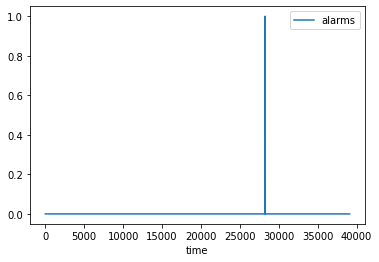

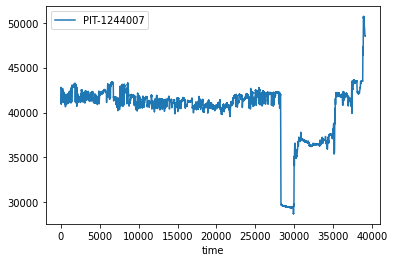

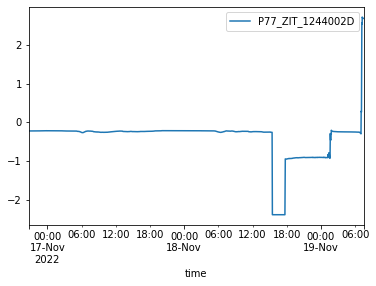

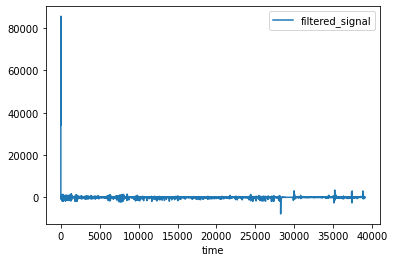

In [29]:
s = Signal()
result = s.signalFilter(supress,  df_select, 'well injection D', 'PIT-1244007' , 'P77_ZIT_1244002D')
result.plot(x='time',y='filtered_signal', kind='line')
plt.show()

5398    1
5399    1
5400    1
5401    1
5402    1
5403    1
5404    1
5405    1
5406    1
5407    1
5408    1
Name: P77_SDY_1210002D, dtype: int64
 2022-11-18 17:59:00 , 2022-11-18 18:09:00 
 iter = 28257 
 time = 2022-11-18 18:09:49.347342 
 signal inputs [39300.6875, 38583.6328125, 37853.69921875, 37222.51171875, 36608.51171875, 36114.7265625, 35608.05859375, 35161.51171875, 34749.3125] kPa 
 signal outputs[-7176.5734375, -7657.46640625, -7832.6546875, -7717.5875, -7333.72734375, -6814.1859375] kPa/min 
  total alarms =  1 


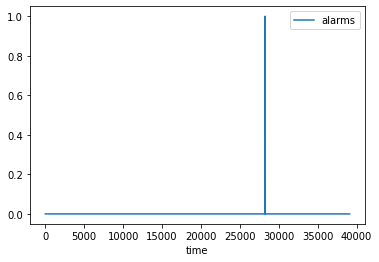

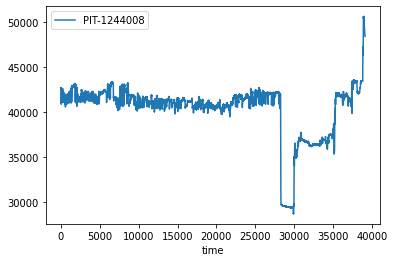

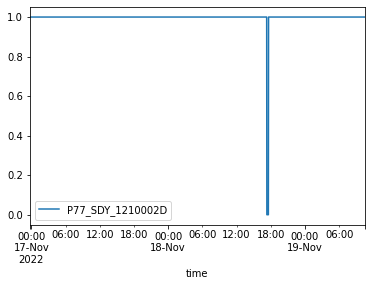

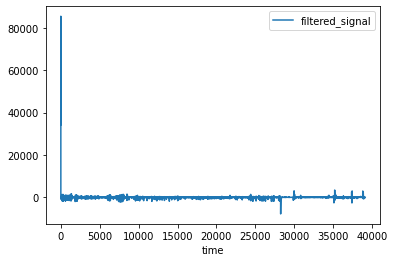

In [12]:
s = Signal()
result = s.signalFilter(supress, df_select, 'well injection D', 'PIT-1244008', 'P77_SDY_1210002D')
result.plot(x='time',y='filtered_signal', kind='line')
plt.show()

5535    1
5536    1
5537    1
5538    1
5539    1
5540    1
5541    1
5542    1
5543    1
5544    1
5545    1
Name: P77_SDY_1210002C, dtype: int64
 2022-11-18 20:16:00 , 2022-11-18 20:26:00 
 iter = 29774 
 time = 2022-11-18 20:26:27.522296 
 signal inputs [40824.96875, 40824.96875, 37196.75390625, 29004.279296875, 28879.759765625, 29300.55078125, 29167.439453125, 29124.5, 29382.130859375] kPa 
 signal outputs[-11512.40078125, -18113.609765625, -21850.026171875, -23386.330078125, -22628.05859375, -19327.023046875] kPa/min 
  total alarms =  1 


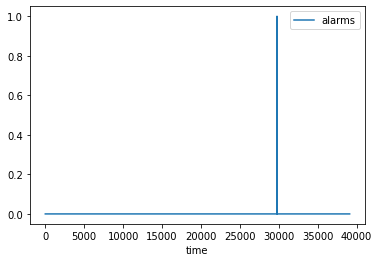

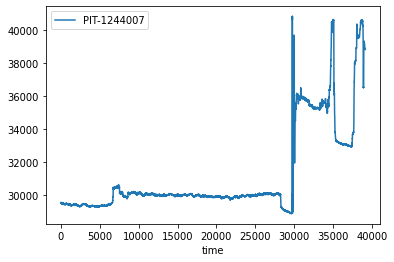

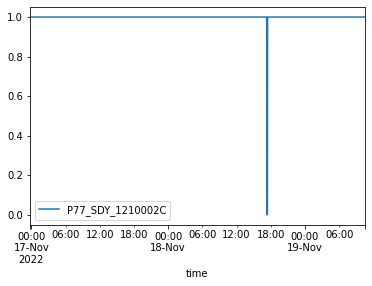

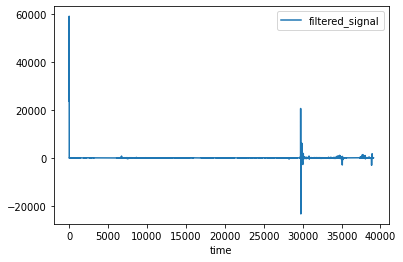

In [13]:
s = Signal()
result = s.signalFilter(supress, df_select, 'well injection C', 'PIT-1244007', 'P77_SDY_1210002C')
result.plot(x='time',y='filtered_signal', kind='line')
plt.show()

5535    1
5536    1
5537    1
5538    1
5539    1
5540    1
5541    1
5542    1
5543    1
5544    1
5545    1
Name: P77_SDY_1210002C, dtype: int64
 2022-11-18 20:16:00 , 2022-11-18 20:26:00 
 iter = 29774 
 time = 2022-11-18 20:26:27.522296 
 signal inputs [40962.3671875, 40962.3671875, 38098.44140625, 29133.08984375, 28982.810546875, 29399.30078125, 29270.490234375, 29227.55078125, 29485.1796875] kPa 
 signal outputs[-11058.12421875, -17843.109375, -21756.431640625, -23458.4703125, -22854.76640625, -19700.578125] kPa/min 
  total alarms =  1 


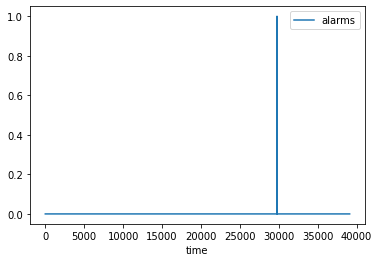

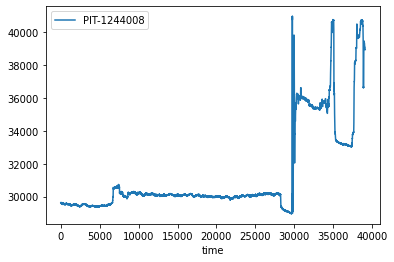

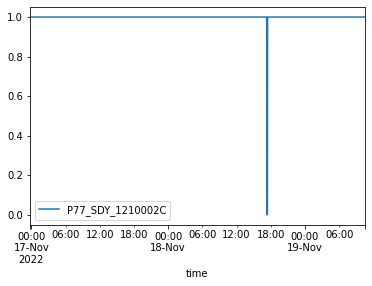

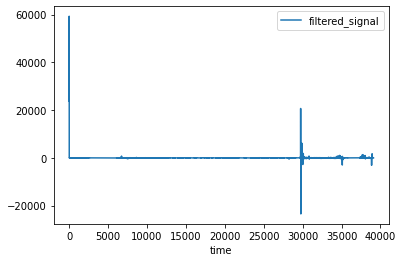

In [14]:
s = Signal()
result = s.signalFilter(supress, df_select, 'well injection C', 'PIT-1244008', 'P77_SDY_1210002C')
result.plot(x='time',y='filtered_signal', kind='line')
plt.show()

<AxesSubplot:xlabel='time'>

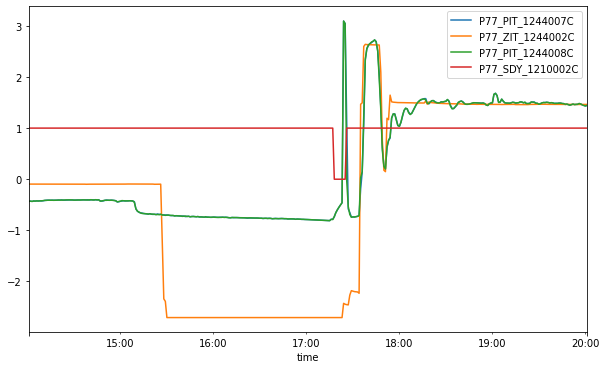

In [16]:
start = '2022-11-18 14:01:00'
end =  '2022-11-18 20:01:00'
select = supress.loc[(supress['time'] >= start )&(supress['time'] <= end)]
select.plot(x='time', y=['P77_PIT_1244007C','P77_ZIT_1244002C','P77_PIT_1244008C', 'P77_SDY_1210002C'], kind='line', figsize=(10, 6))

<AxesSubplot:xlabel='time'>

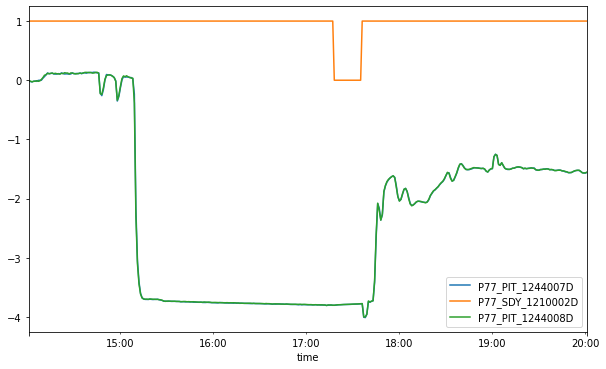

In [17]:
start = '2022-11-18 14:01:00'
end =  '2022-11-18 20:01:00'
select = supress.loc[(supress['time'] >= start )&(supress['time'] <= end)]
select.plot(x='time', y=['P77_PIT_1244007D','P77_SDY_1210002D','P77_PIT_1244008D'], kind='line', figsize=(10, 6))

In [20]:
supress.head()

,time,P77_ZIT_1244001C,P77_ZIT_1244001D,P77_ZIT_1244002C,P77_ZIT_1244002D,P77_PIT_1244007C,P77_PIT_1244008C,P77_PIT_1244007D,P77_PIT_1244008D,P77_SDY_1210002C,P77_SDY_1210002D
2865,2022-11-16 23:46:00,0.0,0.0,-0.362353,-0.219097,-0.631376,-0.627005,-0.131333,-0.042549,1,1
2866,2022-11-16 23:47:00,0.0,0.0,-0.363179,-0.218769,-0.634179,-0.631878,-0.127839,-0.084392,1,1
2867,2022-11-16 23:48:00,0.0,0.0,-0.363179,-0.218769,-0.627981,-0.624158,0.049661,0.060975,1,1
2868,2022-11-16 23:49:00,0.0,0.0,-0.363179,-0.219097,-0.628218,-0.627680,0.065850,0.044681,1,1
2869,2022-11-16 23:50:00,0.0,0.0,-0.363179,-0.219097,-0.629386,-0.631168,0.020658,0.017629,1,1


In [19]:
mask = supress['P77_SDY_1210002D'] == 0
supress.loc[mask]

,time,P77_ZIT_1244001C,P77_ZIT_1244001D,P77_ZIT_1244002C,P77_ZIT_1244002D,P77_PIT_1244007C,P77_PIT_1244008C,P77_PIT_1244007D,P77_PIT_1244008D,P77_SDY_1210002C,P77_SDY_1210002D
5357,2022-11-18 17:18:00,0.0,0.0,-2.707128,-2.385837,-0.736092,-0.729032,-3.804548,-3.803120,0,0
5358,2022-11-18 17:19:00,0.0,0.0,-2.707128,-2.385837,-0.652870,-0.653893,-3.801648,-3.799181,0,0
5359,2022-11-18 17:20:00,0.0,0.0,-2.707128,-2.385837,-0.600663,-0.595406,-3.797984,-3.796680,0,0
5360,2022-11-18 17:21:00,0.0,0.0,-2.707128,-2.385837,-0.548093,-0.547966,-3.795360,-3.795365,0,0
5361,2022-11-18 17:22:00,0.0,0.0,-2.707128,-2.385837,-0.505252,-0.503192,-3.795221,-3.793926,0,0
5362,2022-11-18 17:23:00,0.0,0.0,-2.707128,-2.385837,-0.460941,-0.459961,-3.792732,-3.791425,0,0
5363,2022-11-18 17:24:00,0.0,0.0,-2.428642,-2.385837,3.094306,3.093944,-3.791421,-3.790113,0,0
5364,2022-11-18 17:25:00,0.0,0.0,-2.446279,-2.385837,3.045814,3.042143,-3.791281,-3.788797,0,0
5365,2022-11-18 17:26:00,0.0,0.0,-2.454125,-2.385837,1.136234,-0.026656,-3.789966,-3.788797,1,0
5366,2022-11-18 17:27:00,0.0,0.0,-2.459022,-2.385837,-0.581976,-0.532626,-3.789966,-3.787485,1,0


In [30]:
supress.columns

Index(['time', 'P77_ZIT_1244001C', 'P77_ZIT_1244001D', 'P77_ZIT_1244002C',
       'P77_ZIT_1244002D', 'P77_PIT_1244007C', 'P77_PIT_1244008C',
       'P77_PIT_1244007D', 'P77_PIT_1244008D', 'P77_SDY_1210002C',
       'P77_SDY_1210002D'],
      dtype='object')

In [ ]:
ZIT_1244002C,ABER-CKP,C,ns=2;s=AI.PCS.AI_PV_ZIT_1244002C,ns=2;s=AI.PCS.AI_PV_ZIT_1244002C,%,float,0,1,0,1,PCS,P77
ZIT_1244002D,ABER-CKP,D,9-BUZ-4-RJS,ns=2;s=AI.PCS.AI_PV_ZIT_1244002D,ns=2;s=AI.PCS.AI_PV_ZIT_1244002D,%,float,0,1,0,1,PCS,P77
SDY_1210002C,ESTADO-POCO,C,9-BUZ-3-RJS,ns=2;s=EPT.PSD.DI_EPT_ZSH_1210002C,ns=2;s=EPT.PSD.DI_EPT_ZSH_1210002C,,uint,0,1,0,1,PSD,P77
SDY_1210002D,ESTADO-POCO,D,9-BUZ-4-RJS,ns=2;s=EPT.PSD.DI_EPT_ZSH_1210002D,ns=2;s=EPT.PSD.DI_EPT_ZSH_1210002D,,uint,0,1,0,1,PSD,P77

ZSH_1210001Q,ESTADO-POCO,Q,7-BUZ-12-RJS,ns=2;s=EPT.PSD.DI_EPT_ZSH_1210001Q,,uint,0,1,0,1,PSD,P77
ZIT_1210001L,ABER-CKP,L,9-BUZ-4-RJS,ns=2;s=AI.PCS.AI_PV_ZIT_1210001L,ns=2;s=AI.PCS.AI_PV_ZIT_1210001L,%,float,0,1,0,1,PCS,P77